In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from matplotlib import colors, ticker
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import copy
import isamcalc_lib as isam

In [26]:
## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()
soc_ncscd = soc_ncscd_orig[0,:,:]

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_1d_noco2'
flist = ['mean_bgp2d_1861_1870.nc', 'mean_bgp2d_1871_1880.nc', 'mean_bgp2d_1881_1890.nc', 'mean_bgp2d_1891_1900.nc', \
        'mean_bgp2d_1901_1910.nc', 'mean_bgp2d_1911_1920.nc', 'mean_bgp2d_1921_1930.nc', 'mean_bgp2d_1931_1940.nc', \
        'mean_bgp2d_1941_1950.nc', 'mean_bgp2d_1951_1960.nc', 'mean_bgp2d_1961_1970.nc', 'mean_bgp2d_1971_1980.nc', \
        'mean_bgp2d_1981_1990.nc', 'mean_bgp2d_1991_2000.nc', 'mean_bgp2d_2001_2010.nc']

flen = len(flist)

tas_ctrl = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    tas = nclu.variables['tavg_avg_yr'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    tas_ctrl[i,:,:] = tas
    
#     # Get the topsoil SOC (0-30cm) from 1D model
#     tas_ctrl = np.sum(soclev_ctrl[0:5,:,:], 0)
    
#     soc_sub_ctrl = np.sum(soclev_ctrl[5:7,:,:], 0)+0.3*soclev_ctrl[7,:,:]
    
#     soc_ctrl[i,:,:] = soc_top_ctrl + soc_sub_ctrl
    

mean_bgp2d_1861_1870.nc
mean_bgp2d_1871_1880.nc
mean_bgp2d_1881_1890.nc
mean_bgp2d_1891_1900.nc
mean_bgp2d_1901_1910.nc
mean_bgp2d_1911_1920.nc
mean_bgp2d_1921_1930.nc
mean_bgp2d_1931_1940.nc
mean_bgp2d_1941_1950.nc
mean_bgp2d_1951_1960.nc
mean_bgp2d_1961_1970.nc
mean_bgp2d_1971_1980.nc
mean_bgp2d_1981_1990.nc
mean_bgp2d_1991_2000.nc
mean_bgp2d_2001_2010.nc


In [27]:
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

tas_ctrl[tas_ctrl<0] = np.float('nan')

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
tas_ctrl_ts = np.zeros((flen))

for i in np.arange(0,flen):
    tas_ctrl_perm =  ma.masked_array(tas_ctrl[i,:,:], mask=another_mask.mask)
    val_ctrl = tas_ctrl_perm * grid_area_t
    tas_ctrl_ts[i] = np.nansum(val_ctrl)/np.nansum(grid_area_t)
    

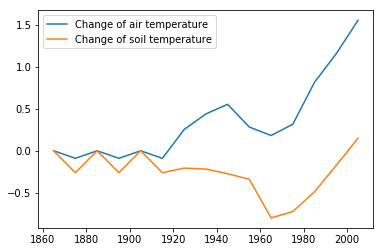

In [47]:
x = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005]
plt.plot(x, tas_ctrl_ts - tas_ctrl_ts[0])
plt.plot(x, st0d_ctrl_ts_dec - st0d_ctrl_ts_dec[0])
plt.legend(['Change of air temperature', 'Change of soil temperature'])
plt.savefig('AT_vs_ST.png')

In [ ]:
plt.imshow(tas_ctrl_perm)

In [ ]:
plt.imshow(grid_area_t)

In [ ]:
# Q10 = 2.8
# Ctrl: [344.85171623, 345.80078603, 346.34139048, 346.8789886 ,
#       347.29449594, 347.74482563, 348.09314122, 348.49433654,
#       348.81126034, 349.18891088, 349.25541638, 349.62803674,
#       349.92415567, 350.29038059, 350.58411073]
# Clim: [344.85217564, 345.80314492, 346.34677599, 346.88850015,
#       347.30917186, 347.76665129, 348.16312954, 348.49581482,
#       348.71102474, 348.98524177, 349.58879441, 350.12537981,
#       350.57307144, 350.65017399, 350.18227684]

# Q10 = 2.4
# Ctrl: [344.5191481 , 345.17887845, 345.52711288, 345.88347095,
#      346.14541027, 346.44376143, 346.66353591, 346.93265238,
#      347.13417957, 347.38880528, 347.57976805, 347.82852077,
#      348.01406415, 348.25970344, 348.4445406]
# Clim: [344.519099  , 345.17987016, 345.53062931, 345.89146083,
#      346.15937421, 346.46507588, 346.73136806, 346.92971148,
#      347.04432112, 347.27269269, 347.76228432, 348.1712788 ,
#      348.5172708 , 348.55997683, 348.13510629]

# Q10 = 1.2
# Ctrl: [341.51694308, 340.48405846, 339.85080782, 339.27679125,
#       338.73511078, 338.22844317, 337.74321153, 337.28312744,
#       336.83653628, 336.41005896, 335.99370333, 335.59304902,
#       335.19949298, 334.81906357, 334.44468435]
# Clim: [341.5174404 , 340.48600423, 339.8548834 , 339.28282276,
#       338.74641193, 338.24610884, 337.79399739, 337.25823478,
#       336.74287354, 336.63611049, 336.60005962, 336.42417635,
#       336.28864333, 336.06231038, 335.65362332]

# Q10 = 1.5
# Ctrl: [342.73772848, 342.28319669, 342.00721199, 341.78753358,
#       341.56793389, 341.38590018, 341.19095113, 341.0281154 ,
#       340.8518669 , 340.70464122, 340.54095463, 340.40364745,
#       340.24788014, 340.11891742, 339.97153639]
# Clim: [342.73751558, 342.28385905, 342.01053194, 341.7929937 ,
#       341.57737078, 341.40072236, 341.24679267, 341.01674135,
#       340.78221579, 340.84982315, 341.00768284, 341.04366537,
#       341.09716929, 341.00718581, 340.65119725]


In [ ]:
# Plot tas
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

#ax2 = fig.add_subplot(111)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,tas_ctrl_perm[:,:],
              norm=colors.Normalize(vmin=260.,vmax=275.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()
#plt.savefig('tas_spatial_preind.png')


In [29]:
## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_1d_noco2'
flist = ['mean_bgc2d_1861_1870.nc', 'mean_bgc2d_1871_1880.nc', 'mean_bgc2d_1881_1890.nc', 'mean_bgc2d_1891_1900.nc', \
        'mean_bgc2d_1901_1910.nc', 'mean_bgc2d_1911_1920.nc', 'mean_bgc2d_1921_1930.nc', 'mean_bgc2d_1931_1940.nc', \
        'mean_bgc2d_1941_1950.nc', 'mean_bgc2d_1951_1960.nc', 'mean_bgc2d_1961_1970.nc', 'mean_bgc2d_1971_1980.nc', \
        'mean_bgc2d_1981_1990.nc', 'mean_bgc2d_1991_2000.nc', 'mean_bgc2d_2001_2010.nc']

flen = len(flist)

npp1d_ctrl = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    npp = nclu.variables['npp'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    npp1d_ctrl[i,:,:] = npp

# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

npp1d_ctrl[npp1d_ctrl<0] = np.float('nan')

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
npp1d_ctrl_ts = np.zeros((flen))

for i in np.arange(0,flen):
    npp_ctrl_perm =  ma.masked_array(npp1d_ctrl[i,:,:], mask=another_mask.mask)
    val_ctrl = npp_ctrl_perm * grid_area_t
    npp1d_ctrl_ts[i] = np.nansum(val_ctrl)/np.nansum(grid_area_t)

# Now check resp_3d
## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_1d_noco2'
flist = ['mean_bgc3d_1861_1870.nc', 'mean_bgc3d_1871_1880.nc', 'mean_bgc3d_1881_1890.nc', 'mean_bgc3d_1891_1900.nc', \
        'mean_bgc3d_1901_1910.nc', 'mean_bgc3d_1911_1920.nc', 'mean_bgc3d_1921_1930.nc', 'mean_bgc3d_1931_1940.nc', \
        'mean_bgc3d_1941_1950.nc', 'mean_bgc3d_1951_1960.nc', 'mean_bgc3d_1961_1970.nc', 'mean_bgc3d_1971_1980.nc', \
        'mean_bgc3d_1981_1990.nc', 'mean_bgc3d_1991_2000.nc', 'mean_bgc3d_2001_2010.nc']

flen = len(flist)

rh1d_ctrl = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    rh = nclu.variables['resp_lev'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    #rh_ctrl[i,:,:] = rh
    
    # Get the topsoil SOC (0-30cm) from 1D model
    rh_top = np.sum(rh[0:5,:,:], 0)
    
    rh_sub = np.sum(rh[5:7,:,:], 0)+0.3*rh[7,:,:]
    
    rh1d_ctrl[i,:,:] = rh_top + rh_sub

# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

rh1d_ctrl[rh1d_ctrl<0] = np.float('nan')

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
rh1d_ctrl_ts = np.zeros((flen))

for i in np.arange(0,flen):
    rh_ctrl_perm =  ma.masked_array(rh1d_ctrl[i,:,:], mask=another_mask.mask)
    val_ctrl = rh_ctrl_perm * grid_area_t
    rh1d_ctrl_ts[i] = np.nansum(val_ctrl)/np.nansum(grid_area_t)

mean_bgc2d_1861_1870.nc
mean_bgc2d_1871_1880.nc
mean_bgc2d_1881_1890.nc
mean_bgc2d_1891_1900.nc
mean_bgc2d_1901_1910.nc
mean_bgc2d_1911_1920.nc
mean_bgc2d_1921_1930.nc
mean_bgc2d_1931_1940.nc
mean_bgc2d_1941_1950.nc
mean_bgc2d_1951_1960.nc
mean_bgc2d_1961_1970.nc
mean_bgc2d_1971_1980.nc
mean_bgc2d_1981_1990.nc
mean_bgc2d_1991_2000.nc
mean_bgc2d_2001_2010.nc
mean_bgc3d_1861_1870.nc
mean_bgc3d_1871_1880.nc
mean_bgc3d_1881_1890.nc
mean_bgc3d_1891_1900.nc
mean_bgc3d_1901_1910.nc
mean_bgc3d_1911_1920.nc
mean_bgc3d_1921_1930.nc
mean_bgc3d_1931_1940.nc
mean_bgc3d_1941_1950.nc
mean_bgc3d_1951_1960.nc
mean_bgc3d_1961_1970.nc
mean_bgc3d_1971_1980.nc
mean_bgc3d_1981_1990.nc
mean_bgc3d_1991_2000.nc
mean_bgc3d_2001_2010.nc


In [30]:
# Check the NPP and Rh for 0D case
# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_0d_noco2_st'
flist = ['mean_bgc2d_1861_1870.nc', 'mean_bgc2d_1871_1880.nc', 'mean_bgc2d_1881_1890.nc', 'mean_bgc2d_1891_1900.nc', \
        'mean_bgc2d_1901_1910.nc', 'mean_bgc2d_1911_1920.nc', 'mean_bgc2d_1921_1930.nc', 'mean_bgc2d_1931_1940.nc', \
        'mean_bgc2d_1941_1950.nc', 'mean_bgc2d_1951_1960.nc', 'mean_bgc2d_1961_1970.nc', 'mean_bgc2d_1971_1980.nc', \
        'mean_bgc2d_1981_1990.nc', 'mean_bgc2d_1991_2000.nc', 'mean_bgc2d_2001_2010.nc']

flen = len(flist)

npp0d_ctrl = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    npp = nclu.variables['npp'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    npp0d_ctrl[i,:,:] = npp

# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

npp0d_ctrl[npp0d_ctrl<0] = np.float('nan')

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
npp0d_ctrl_ts = np.zeros((flen))

for i in np.arange(0,flen):
    npp_ctrl_perm =  ma.masked_array(npp0d_ctrl[i,:,:], mask=another_mask.mask)
    val_ctrl = npp_ctrl_perm * grid_area_t
    npp0d_ctrl_ts[i] = np.nansum(val_ctrl)/np.nansum(grid_area_t)

# Now check resp_3d
## Code to plot the impact from CO2 and climate separately
# Control - noclimate = Climate impact
# Control - noco2 = CO2 effect

# Use the NCSCD permafrost mask, which is the norther high latitude permafrost region without greenland
# The mask Mcguire et al., 2016 used including alpine permafrost (Tiebet and the Alps)
# Alpine permafrost to be treated as having a very small amount of SOC, though for the paper we have 
# to consider the whole region.
mask_permafrost = copy.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = copy.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = copy.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp
#new_mask = np.logical_or(another_mask, mask_permafrost)

# Background time series
respath_ctrl='/data/jain1/d/sshu3/SBGC_0d_noco2_st'
flist = ['mean_bgc2d_1861_1870.nc', 'mean_bgc2d_1871_1880.nc', 'mean_bgc2d_1881_1890.nc', 'mean_bgc2d_1891_1900.nc', \
        'mean_bgc2d_1901_1910.nc', 'mean_bgc2d_1911_1920.nc', 'mean_bgc2d_1921_1930.nc', 'mean_bgc2d_1931_1940.nc', \
        'mean_bgc2d_1941_1950.nc', 'mean_bgc2d_1951_1960.nc', 'mean_bgc2d_1961_1970.nc', 'mean_bgc2d_1971_1980.nc', \
        'mean_bgc2d_1981_1990.nc', 'mean_bgc2d_1991_2000.nc', 'mean_bgc2d_2001_2010.nc']

flen = len(flist)

rh0d_ctrl = np.zeros((flen, 360, 720))

for i in np.arange(0,flen):
    # 1D
    print(flist[i])
    fp=respath_ctrl+'/'+flist[i]
    nclu=NetCDFFile(fp,'r')
    rh = nclu.variables['resp'][:]
    latnc = nclu.variables['lat'][:]
    lonnc = nclu.variables['lon'][:]
    nclu.close()
    
    rh0d_ctrl[i,:,:] = rh
    
# Calculate total numbers for paper
# Mask all regions outside the northern permafrost extent

rh0d_ctrl[rh0d_ctrl<0] = np.float('nan')

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
rh0d_ctrl_ts = np.zeros((flen))

for i in np.arange(0,flen):
    rh_ctrl_perm =  ma.masked_array(rh0d_ctrl[i,:,:], mask=another_mask.mask)
    val_ctrl = rh_ctrl_perm * grid_area_t
    rh0d_ctrl_ts[i] = np.nansum(val_ctrl)/np.nansum(grid_area_t)
    

mean_bgc2d_1861_1870.nc
mean_bgc2d_1871_1880.nc
mean_bgc2d_1881_1890.nc
mean_bgc2d_1891_1900.nc
mean_bgc2d_1901_1910.nc
mean_bgc2d_1911_1920.nc
mean_bgc2d_1921_1930.nc
mean_bgc2d_1931_1940.nc
mean_bgc2d_1941_1950.nc
mean_bgc2d_1951_1960.nc
mean_bgc2d_1961_1970.nc
mean_bgc2d_1971_1980.nc
mean_bgc2d_1981_1990.nc
mean_bgc2d_1991_2000.nc
mean_bgc2d_2001_2010.nc
mean_bgc2d_1861_1870.nc
mean_bgc2d_1871_1880.nc
mean_bgc2d_1881_1890.nc
mean_bgc2d_1891_1900.nc
mean_bgc2d_1901_1910.nc
mean_bgc2d_1911_1920.nc
mean_bgc2d_1921_1930.nc
mean_bgc2d_1931_1940.nc
mean_bgc2d_1941_1950.nc
mean_bgc2d_1951_1960.nc
mean_bgc2d_1961_1970.nc
mean_bgc2d_1971_1980.nc
mean_bgc2d_1981_1990.nc
mean_bgc2d_1991_2000.nc
mean_bgc2d_2001_2010.nc


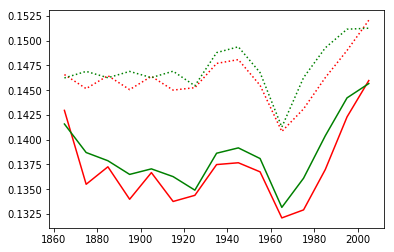

In [32]:
x = [1865, 1875, 1885, 1895, 1905, 1915, 1925, 1935, 1945, 1955, 1965, 1975, 1985, 1995, 2005]
plt.plot(x, rh0d_ctrl_ts, color='red')
plt.plot(x, npp0d_ctrl_ts, color='green') 
plt.plot(x, rh1d_ctrl_ts, color='red', linestyle=':')
plt.plot(x, npp1d_ctrl_ts, color='green', linestyle=':')
#plt.legend(['Rh - 0D', 'NPP - 0D', 'Rh - 1D', 'NPP - 1D'])
plt.savefig('NPP_vs_Rh_ST.png')

In [ ]:
# Plot NPP diff
npp0d_ctrl_perm =  ma.masked_array(npp0d_ctrl[14,:,:], mask=another_mask.mask)
npp1d_ctrl_perm =  ma.masked_array(npp1d_ctrl[14,:,:], mask=another_mask.mask)

fig = plt.figure(figsize=(20,16))

map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,npp0d_ctrl_perm - npp1d_ctrl_perm,
              norm=colors.Normalize(vmin=-0.04,vmax=0.04),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()

In [33]:
# Check soil temperature for 0D
# Soil temperature
# First 0D
respath='/data/jain1/d/sshu3/SBGC_0d_noco2/'
prefix='Global_0DSBGC.bgp-monthly_3d_'
suffix='.nc'
month=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nlat = 360
nlon = 720

# Get the mean of first 1m soil
st_year = np.zeros((360, 720))
st_0d_preind_series = np.zeros((10, 360, 720))
st_0d_contemp_series = np.zeros((10, 360, 720))
st_0d_preind_series = np.zeros((10, 360, 720))
st_0d_series = np.zeros((155, 360, 720))
st_0d_preind = np.zeros((360, 720))
st_0d_contemp = np.zeros((360, 720))

# Read the 3D files
# 1861 - 1870
for y in np.arange(1861,2011):
    print(y)
    st_year = np.zeros((12,360,720))
    for i in np.arange(0,12):
    #for i in np.arange(5,8):
        fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
        nclu=NetCDFFile(fp,'r')
        tss = nclu.variables['c_tss'][:]
        latnc = nclu.variables['lat'][:]
        lonnc = nclu.variables['lon'][:]
        nclu.close()
        
        # Only use snow-free temperature
        # Also, we shall do a depth-werighted average
        snow_bottom  = tss[4,:,:]
        for l in np.arange(5,13):
            soilt = tss[i,:,:]
            soilt[snow_bottom>0] = np.float('nan')
            tss[i,:,:] = soilt
        #st = (np.nansum(tss[5:12,:,:], axis=0)+0.3*tss[12,:,:])/7.3
        st = np.average(tss[5:13,:,:], axis=0)#, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
        st_year[i,:,:] = st
        st_0d_series[(y-1861),:,:] = np.nanmean(st_year, axis=0)
        if(y in np.arange(1861,1871)):   
            st_0d_preind_series[(y-1861),:,:] = np.nanmean(st_year, axis=0)
        if(y in np.arange(2001,2011)):
            st_0d_contemp_series[(y-2001),:,:] = np.nanmean(st_year, axis=0)
    
# # 2001 - 2010
# for y in np.arange(2001,2011):
#     st_year = np.zeros((12,360,720))
#     for i in np.arange(0,12):
#     #for i in np.arange(5,8):
#         fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
#         nclu=NetCDFFile(fp,'r')
#         tss = nclu.variables['c_tss'][:]
#         latnc = nclu.variables['lat'][:]
#         lonnc = nclu.variables['lon'][:]
#         nclu.close()

#         snow_bottom  = tss[4,:,:]
#         for l in np.arange(5,13):
#             soilt = tss[i,:,:]
#             soilt[snow_bottom>0] = np.float('nan')
#             tss[i,:,:] = soilt
#         st = np.average(tss[5:13,:,:], axis=0)#, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
#         st_year[i,:,:] = st
    
#     st_0d_contemp_series[(y-2001),:,:] = np.nanmean(st_year, axis=0)

st_0d_preind = np.mean(st_0d_preind_series, axis=0)
st_0d_preind[st_0d_preind<200] = np.float('nan')
st_0d_contemp = np.mean(st_0d_contemp_series, axis=0)
st_0d_diff = st_0d_contemp - st_0d_preind
## Delete anomaly grids
#st_0d_diff[st_0d_diff<-2] = 0



1861


/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010


In [35]:
np.shape(st_0d_preind)

(360, 720)

In [36]:
# Get the regional area-weighted mean ST time series
# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

st0d_ctrl_ts = np.zeros((150))
# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
for yr in np.arange(0,150):
    print(yr)
    st0d_perm =  ma.masked_array(st_0d_series[yr,:,:], mask=another_mask.mask)
    st0d_perm[st0d_perm<0] = np.float('nan')
    val_ctrl = st0d_perm * grid_area_t
    st0d_ctrl_ts[yr] = np.nansum(val_ctrl)/np.nansum(grid_area_t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [42]:
# Calculate the mean of every decade
st0d_ctrl_ts_dec = np.zeros((15))
for dec in np.arange(0,15):
    st0d_ctrl_ts_dec[dec] = np.nanmean(st0d_ctrl_ts[(dec*10):(dec*10+9)])

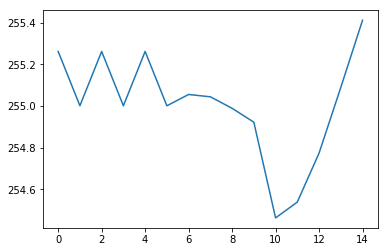

In [43]:
plt.plot(st0d_ctrl_ts_dec)

In [ ]:
st0d_preind_perm =  ma.masked_array(st_0d_preind, mask=another_mask.mask)
st0d_preind_perm[st0d_preind_perm<0] = np.float('nan')
st0d_diff_perm =  ma.masked_array(st_0d_diff, mask=another_mask.mask)
#st0d_diff_perm[st0d_diff_perm<0] = np.float('nan')
# st1d_preind_perm =  ma.masked_array(st_1d_preind, mask=another_mask.mask)

# Plot ST
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

#ax2 = fig.add_subplot(111)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,st0d_diff_perm[:,:],
              norm=colors.Normalize(vmin=-2.,vmax=2.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()

In [ ]:
# Check soil temperatur using the resp as weight for 1D
respath='/data/jain1/d/sshu3/SBGC_1d_noco2/'
prefix='Global_1DSBGC.bgp-monthly_3d_'
prefix_resp='Global_1DSBGC.bgc-yearly-3d_'
suffix='.nc'
month=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nlat = 360
nlon = 720

# Get the mean of first 1m soil
st_year = np.zeros((360, 720))
st_1d_preind_series = np.zeros((10, 360, 720))
st_1d_contemp_series = np.zeros((10, 360, 720))
st_1d_preind = np.zeros((360, 720))
st_1d_contemp = np.zeros((360, 720))
resp_wt = np.zeros((10,360,720))

# Read the 3D files
# 1861 - 1870
for y in np.arange(1861,1871):
    fp=respath+prefix_resp+str(y)+'.nc'
    nclu=NetCDFFile(fp,'r')
    resp = nclu.variables['resp_lev'][:]
    nclu.close()
    
    resp_all = np.nansum(resp[0:7,:,:], axis=0)+0.3*resp[7,:,:]
    for lev in np.arange(0,7):
        resp_wt[lev,:,:] = resp[lev,:,:] / (resp_all+1e-6)
        if(lev == 1):
            tp = resp_wt[1,:,:]
            tp[resp_all<=0.] = 1.
            resp_wt[1,:,:] = tp
    resp_wt[7,:,:] = 0.3*resp[7,:,:] / (resp_all+1e-6)
    
    st_year = np.zeros((12,360,720))
    for i in np.arange(0,12):
        fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
        nclu=NetCDFFile(fp,'r')
        tss = nclu.variables['c_tss'][:]
        latnc = nclu.variables['lat'][:]
        lonnc = nclu.variables['lon'][:]
        nclu.close()
        
        # Only use snow-free temperature
        # Also, we shall do a depth-werighted average
        snow_bottom  = tss[4,:,:]
        for l in np.arange(5,13):
            soilt = tss[i,:,:]
            soilt[snow_bottom>0] = np.float('nan')
            tss[i,:,:] = soilt
            
        # Use depth as weight
        #st = np.average(tss[5:13,:,:], axis=0, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
        # Use resp as weight
        st = np.average(tss[5:13,:,:], axis=0, weights=resp_wt[0:8,:,:])
        #st = np.sum(tss[5:10,:,:], axis=0)/5
        st_year[i,:,:] = st
        #st_year = st_year + st/3.
        
    st_1d_preind_series[(y-1861),:,:] = np.nanmean(st_year, axis=0)
    
# 2001 - 2010
for y in np.arange(2001,2011):
    fp=respath+prefix_resp+str(y)+'.nc'
    nclu=NetCDFFile(fp,'r')
    resp = nclu.variables['resp_lev'][:]
    nclu.close()
    
    resp_all = np.nansum(resp[0:7,:,:], axis=0)+0.3*resp[7,:,:]
    for lev in np.arange(0,7):
        resp_wt[lev,:,:] = resp[lev,:,:] / (resp_all+1e-6)
        if(lev == 1):
            tp = resp_wt[1,:,:]
            tp[resp_all<=0.] = 1.
            resp_wt[1,:,:] = tp
    resp_wt[7,:,:] = 0.3*resp[7,:,:] / (resp_all+1e-6)
    
    st_year = np.zeros((12,360,720))
    for i in np.arange(0,12):
    #for i in np.arange(5,8):
        fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
        nclu=NetCDFFile(fp,'r')
        tss = nclu.variables['c_tss'][:]
        nclu.close()

        snow_bottom  = tss[4,:,:]
        for l in np.arange(5,13):
            soilt = tss[i,:,:]
            soilt[snow_bottom>0] = np.float('nan')
            tss[i,:,:] = soilt
        # Use depth as weight
        #st = np.average(tss[5:13,:,:], axis=0, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
        # Use resp as weight
        st = np.average(tss[5:13,:,:], axis=0, weights=resp_wt[0:8,:,:])
        #st = np.sum(tss[5:10,:,:], axis=0)/5
        st_year[i,:,:] = st
        #st_year = st_year + st/3.
    
    st_1d_contemp_series[(y-2001),:,:] = np.nanmean(st_year, axis=0)

st_1d_preind = np.mean(st_1d_preind_series, axis=0)
st_1d_preind[st_1d_preind<200] = np.float('nan')
st_1d_contemp = np.mean(st_1d_contemp_series, axis=0)
st_1d_diff = st_1d_contemp - st_1d_preind
## Delete anomaly grids
#st_0d_diff[st_0d_diff<-2] = 0


In [ ]:
st1d_preind_perm =  ma.masked_array(st_1d_preind, mask=another_mask.mask)
st1d_preind_perm[st1d_preind_perm<0] = np.float('nan')
st1d_diff_perm =  ma.masked_array(st_1d_diff, mask=another_mask.mask)
#st1d_diff_perm[st1d_diff_perm<0] = np.float('nan')

# Plot ST
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

#ax2 = fig.add_subplot(111)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,st1d_diff_perm[:,:]-st0d_diff_perm[:,:],
              norm=colors.Normalize(vmin=-0.1,vmax=0.1),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()
#plt.savefig('Change_ST_diff.png')

In [ ]:
totwt = np.nansum(resp_wt[0:8,:,:], axis=0)
totwt_perm =  ma.masked_array(totwt, mask=another_mask.mask)
totwt_perm[totwt_perm<0] = np.float('nan')
# st1d_preind_perm =  ma.masked_array(st_1d_preind, mask=another_mask.mask)

# Plot ST
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

#ax2 = fig.add_subplot(111)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,totwt_perm[:,:],
              norm=colors.Normalize(vmin=0.,vmax=1.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()

In [ ]:
# Get the mean temperature
dst_diff = st1d_diff_perm[:,:]-st0d_diff_perm[:,:]

# Get the grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
#val = np.ones((nlat, nlon))*float("nan")
#val_0d = np.ones((nlat, nlon))*float("nan")
#val_obs = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t =  ma.masked_array(grid_area, mask=another_mask.mask)
val_ctrl = dst_diff * grid_area_t
dst_ctrl_ts = np.nansum(val_ctrl)/np.nansum(grid_area_t)

In [22]:
# Examine the temperature sensitivity of 0D and 1D model separately
x = np.arange(-10,31,dtype='float')
sz = len(x)
tsen_1d_abg = np.zeros((sz))
tsen_1d_blg = np.zeros((sz))
tsen_0d_abg = np.zeros((sz))
tsen_0d_blg = np.zeros((sz))

for i in np.arange(0,sz):
    tsen_1d_abg[i] = isam.q10_1dag(2.8, x[i])
    tsen_1d_blg[i] = isam.q10_1dbg(2.8, x[i])
    tsen_0d_abg[i] = isam.tsen_0dag(x[i])
    tsen_0d_blg[i] = isam.tsen_0dbg(x[i])

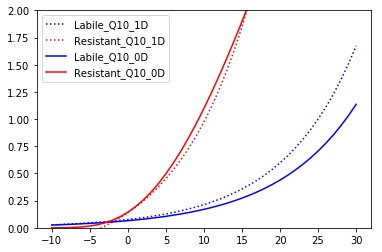

In [25]:
plt.plot(x,tsen_1d_abg,color='blue',linestyle=':')
plt.plot(x,tsen_1d_blg,color='red',linestyle=':')
plt.plot(x,tsen_0d_abg,color='blue',linestyle='-')
plt.plot(x,tsen_0d_blg,color='red',linestyle='-')
plt.ylim([0, 2])
plt.legend(['Labile_Q10_1D', 'Resistant_Q10_1D', 'Labile_Q10_0D', 'Resistant_Q10_0D'])
#plt.xlim([-10, 10])
#plt.show()
plt.savefig('Q10_calibration.png')

In [ ]:
plt.imshow(dsoc)

In [ ]:
lonnc2

In [ ]:
lonnc2 % 360
